# Used Modules

In [1]:
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectFromModel
import warnings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
# Change the color of the plots (for the custom black Jupyter theme)
plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')

# Data Exploration

## Read the data

In [3]:
df_train = pd.read_csv('xtrain.txt', header = None, sep = '\t', index_col = 0)
df_test = pd.read_csv('xtest.txt', header = None, sep = '\t', index_col = 0)
# df_train.set_index(0, inplace = True)
df_train = df_train.transpose()
df_test = df_test.transpose()
df_train.head()

,x10006_at,x10007_at,x100129361_at,x100130449_at,x100130633_at,x100133941_at,x10014_at,x10016_at,x100188893_at,x10019_at,...,x9976_at,x9978_at,x997_at,x9984_at,x9987_at,x9988_at,x9989_at,x9994_at,x9997_at,x9_at
1,8.44,7.84,9.23,2.20,4.93,10.31,7.85,9.91,11.37,3.48,...,7.71,11.32,6.37,8.63,8.61,7.42,8.79,4.70,7.23,8.28
2,7.93,8.47,7.77,2.48,6.70,11.03,3.33,9.53,10.91,4.28,...,9.98,10.40,5.96,7.61,9.51,8.20,9.27,4.70,6.70,12.78
3,7.53,7.49,9.49,5.66,5.99,8.87,3.48,8.02,10.73,4.07,...,8.34,10.57,6.92,8.20,8.71,8.56,8.90,4.70,7.70,12.22
4,7.72,8.38,8.03,5.22,6.95,2.73,4.06,9.26,10.90,7.40,...,9.05,10.92,5.73,8.44,9.18,7.86,9.30,5.58,7.95,12.18
5,7.89,7.75,6.99,2.20,7.06,11.38,3.65,9.22,10.37,3.89,...,9.16,10.73,7.45,7.79,9.15,7.97,8.50,4.70,6.63,12.12


In [4]:
# Read the y values
df_y = pd.read_csv('ytrain.txt', header = None)
df_y.index = 1+np.arange(184)

# Classes counts
df_y.iloc[:,0].value_counts()

-1    118
 1     66
Name: 0, dtype: int64

In [5]:
# combine all data in one data frame
df_all = df_train.copy()
df_all['y'] = df_y

# Save the whole data 
df_all.to_csv('breast_genes.csv', index = False)

## Check null values

In [6]:
np.sum(df_y.isnull())

0    0
dtype: int64

# Visualization

 ## PCA

### Plotting the first two components

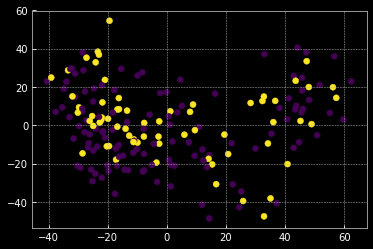

In [7]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_train.values)

df = df_train.copy()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

plt.scatter(df['pca-one'], df['pca-two'], c = df_y.values.reshape(-1,));

### Visualizing 3 components from PCA

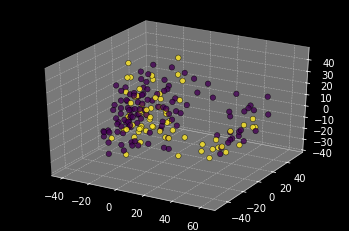

In [8]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.scatter(df['pca-one'], df['pca-two'], df['pca-three'], alpha=0.8, c=df_y.values.reshape(-1,), edgecolors='none', s=30)

### How much the first 3 components explain the variance in data

In [9]:
np.sum(pca.explained_variance_ratio_)

0.28581363103619212

This means taking only the 3 components will explain 28% of the data, which won't be representative of all the data.

Instead, if we took the over 100 components, they will explain 90%+% of the data

## t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 184 samples in 0.000s...
[t-SNE] Computed neighbors for 184 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 184 / 184
[t-SNE] Mean sigma: 24.668625
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.381451
[t-SNE] KL divergence after 300 iterations: 0.821153


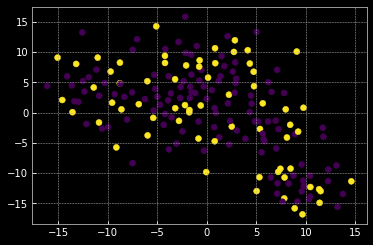

In [10]:
n_sne = 7000

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_train.values)

plt.scatter(tsne_results[:,0], tsne_results[:,1], c = df_y.values.reshape(-1,))

## ISOMAP

In [11]:
# n_neighbors = 10
# n_components = 2
# y_iso = Isomap(n_neighbors, n_components).fit_transform(x)

# ax = fig.add_subplot(111)
# plt.scatter(y_iso[:, 0], y_iso[:, 1], c=y.reshape(-1,))#, cmap=plt.cm.Spectral)

# plt.axis('tight')
# plt.show()

# Handle Class Imbalance with SMOTE

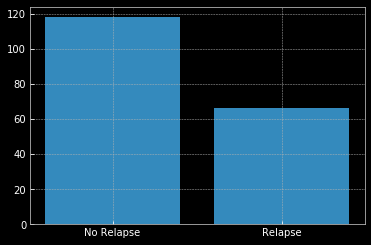

In [12]:
objects = ('No Relapse', 'Relapse')
y_pos = np.arange(len(objects))
plt.bar(np.arange(2), df_y[0].value_counts())
plt.xticks(y_pos, objects);

In [13]:
print('Original dataset shape %s' % Counter(df_y.values.reshape(-1,)))
rus = SMOTE(random_state=42)
x_res, y_res = rus.fit_resample(df_train.values, df_y.values)

print('Original dataset shape %s' % Counter(y_res))

Original dataset shape Counter({-1: 118, 1: 66})
Original dataset shape Counter({-1: 118, 1: 118})


# Feature Selection with Lasso

In [14]:
lass = Lasso(
        max_iter=3000,
        alpha= 0.000091,
        random_state= 42 
        )
lass.fit(df_train, df_y)
lass.coef_.min(), lass.coef_.max()

# selected features
good_features = np.abs(np.array(lass.coef_)) > 0
df_lasso = x_res[:, good_features]

In [15]:
df_lasso.shape

(236, 358)

In [16]:
good_features.shape

(4654,)

# Data scaling and Train-Test split

In [17]:
# If using lasso to select some features
x = df_lasso
y = y_res

# If using all features
# x = df_main.drop(['y'], axis=1)
# y = np.array(df_y.values).reshape(-1,)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, shuffle=True)
x.shape

(236, 358)

# Applying Different Models

We will try the following models:
`1` Random Forest.
`2` Gradient Boosting.
`3` SVM (Linear and non-linear).
`4` KNN.

In [18]:
def train(model, xtrain, ytrain, xtest, ytest):
    
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)
    
    kfold = KFold(n_splits=10)#, random_state=42)
    result = cross_val_score(model, xtrain, ytrain, cv=kfold, scoring='balanced_accuracy')
    print(f'Accuracy =  {model.score(xtest, ytest):.4} - ROC = {roc_auc_score(ytest, pred):.4} - '
          f' CV score mean = {result.mean():.4} - CV score std = {result.std():.4}')
    
    # plot the roc score after k-fold
    y_score = model.predict_proba(x_test)
    y_score = y_score[:,1]
    fp_rate, tp_rate, _ = roc_curve(ytest, y_score)
    roc_auc = auc(fp_rate, tp_rate, reorder=False)
    plt.figure()
    lw = 2
    plt.plot(fp_rate, tp_rate, color='darkorange', lw = lw, label=f'ROC curve (area = {roc_auc:.2} - mean = {result.mean():.2})' )
    plt.plot([0, 1], [0, 1], color='yellow', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return model.score(xtest, ytest), roc_auc_score(ytest, pred), result.mean(), result.std()
    

Accuracy =  0.7564 - ROC = 0.7599 -  CV score mean = 0.6973 - CV score std = 0.1415


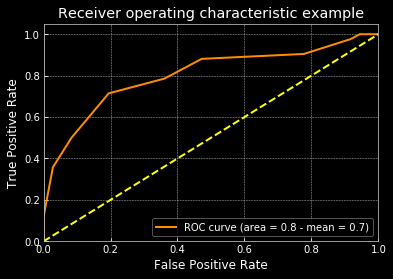

In [19]:
# Random Forest with default number of estimators
rf = RandomForestClassifier(random_state=42)
rf_acc, rf_auc, rf_mean, rf_std = train(rf, x_train, y_train, x_test, y_test)

Accuracy =  0.8077 - ROC = 0.8135 -  CV score mean = 0.7894 - CV score std = 0.1149


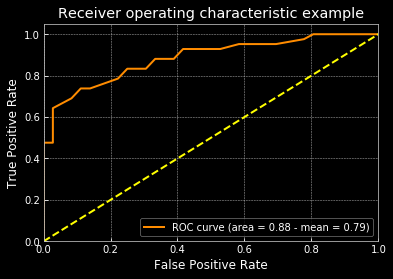

In [20]:
# RandomForest with 100 estimators
rf_100 = RandomForestClassifier(n_estimators= 100, random_state=42)
rf_100_acc, rf_100_auc, rf_100_mean, rf_100_std = train(rf_100, x_train, y_train, x_test, y_test)

Accuracy =  0.7051 - ROC = 0.7123 -  CV score mean = 0.8172 - CV score std = 0.07966


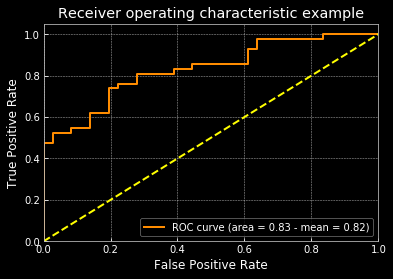

In [21]:
# Gradient boosting with default parameters
lgb = LGBMClassifier()
lgb_acc, lgb_auc, lgb_mean, lgb_std = train(lgb, x_train, y_train, x_test, y_test)

Accuracy =  0.9615 - ROC = 0.9583 -  CV score mean = 0.9557 - CV score std = 0.0436


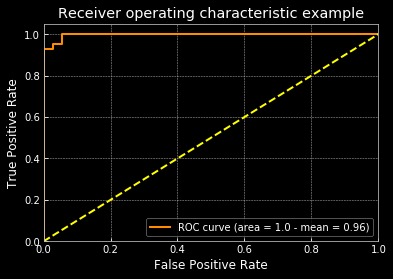

In [22]:
# Linear SVM with default parameters
clf_lin = SVC(kernel = 'linear', random_state=42, probability=True)
clf_lin_acc, clf_lin_auc, clf_lin_mean, clf_lin_std = train(clf_lin, x_train, y_train, x_test, y_test)

Accuracy =  0.8718 - ROC = 0.879 -  CV score mean = 0.8418 - CV score std = 0.1082


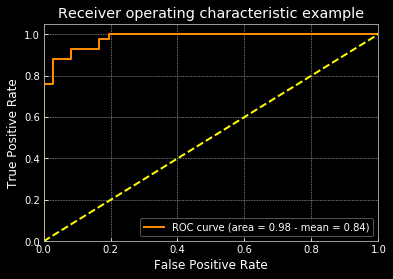

In [23]:
# SVM with default parameters (rbf kernel)
clf = SVC(random_state=42, probability=True)
clf_acc, clf_auc, clf_mean, clf_std = train(clf, x_train, y_train, x_test, y_test)

Accuracy =  0.7308 - ROC = 0.7103 -  CV score mean = 0.6548 - CV score std = 0.08316


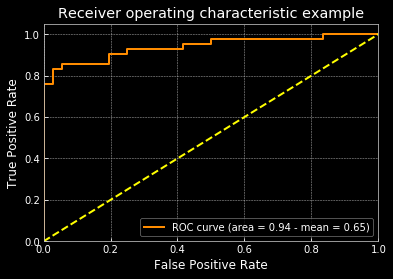

In [24]:
# SVM with polynomial kernel
clf_poly = SVC(random_state=42 , C = 10, kernel = 'poly', probability=True) # (sigmoid 62) and (rbf 65), (poly 70)
clf_poly_acc, clf_poly_auc, clf_poly_mean, clf_poly_std = train(clf_poly, x_train, y_train, x_test, y_test)

Accuracy =  0.9744 - ROC = 0.9722 -  CV score mean = 0.9367 - CV score std = 0.07229


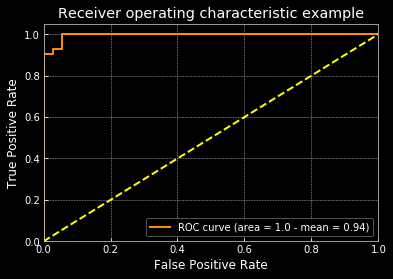

In [25]:
# Logistic Regression with default parameters
lr = LogisticRegression(random_state=42)
lr_acc, lr_auc, lr_mean, lr_std = train(lr, x_train, y_train, x_test, y_test)

Accuracy =  0.9744 - ROC = 0.9722 -  CV score mean = 0.9367 - CV score std = 0.07229


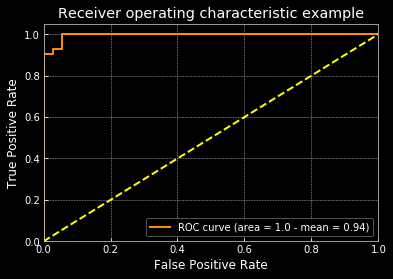

In [26]:
# Logistic Regression with dual form 
lr_dual = LogisticRegression(random_state=42, dual =True) # best one till now
lr_dual_acc, lr_dual_auc, lr_dual_mean, lr_dual_std = train(lr_dual, x_train, y_train, x_test, y_test)

Accuracy =  0.9487 - ROC = 0.9444 -  CV score mean = 0.9628 - CV score std = 0.04442


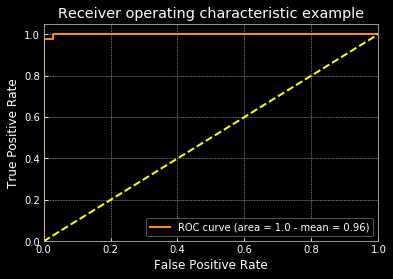

In [27]:
# Logistic Regression with C = 0.01
# C : Inverse of regularization strength; must be a positive float. 
# Like in support vector machines, smaller values specify stronger regularization.

lr_100 = LogisticRegression(random_state=42, C = 100)
lr_100_acc, lr_100_auc, lr_100_mean, lr_100_std = train(lr_100, x_train, y_train, x_test, y_test)

Accuracy =  0.641 - ROC = 0.6151 -  CV score mean = 0.6565 - CV score std = 0.08824


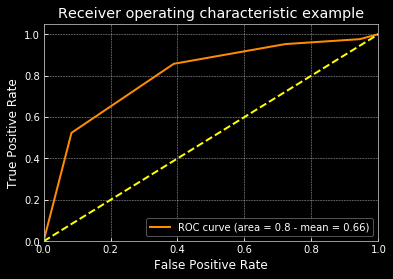

In [28]:
# KNN with default params
knn = KNeighborsClassifier()
knn_acc, knn_auc, knn_mean, knn_std = train(knn, x_train, y_train, x_test, y_test)

In [29]:
# plot a comparison between them
# RandomForest
rf_acc, rf_auc, rf_mean, rf_std
# RandomForest - 100 estimators
rf_100_acc, rf_100_auc, rf_100_mean, rf_100_std 
# GradientBoosting
lgb_acc, lgb_auc, lgb_mean, lgb_std
# Linear SVM
clf_lin_acc, clf_lin_auc, clf_lin_mean, clf_lin_std
# SVM with RBF kernel
clf_acc, clf_auc, clf_mean, clf_std
# SVM with polynomial kernel
clf_poly_acc, clf_poly_auc, clf_poly_mean, clf_poly_std
# Logistic Regression
lr_acc, lr_auc, lr_mean, lr_std
# Logistic Regression - dual
lr_dual_acc, lr_dual_auc, lr_dual_mean, lr_dual_std
# Logistic Regression - C=100
lr_100_acc, lr_100_auc, lr_100_mean, lr_100_std

(0.94871794871794868,
 0.94444444444444442,
 0.96279761904761918,
 0.044422405427109193)

Text(0.5,1,'Mean of ROC cross validated scores')

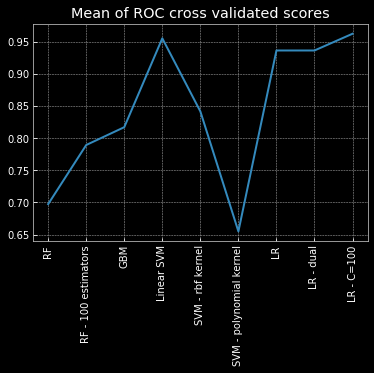

In [30]:
means = [rf_mean, rf_100_mean, lgb_mean, clf_lin_mean, clf_mean, clf_poly_mean, lr_mean, lr_dual_mean, lr_100_mean]
names = ['RF', 'RF - 100 estimators', 'GBM', 'Linear SVM', 'SVM - rbf kernel', 'SVM - polynomial kernel', 'LR', 'LR - dual', 'LR - C=100']
plt.plot(names, means)
plt.xticks(rotation=90)
plt.title('Mean of ROC cross validated scores')

Text(0.5,1,'Standard Deviation of ROC cross validated scores')

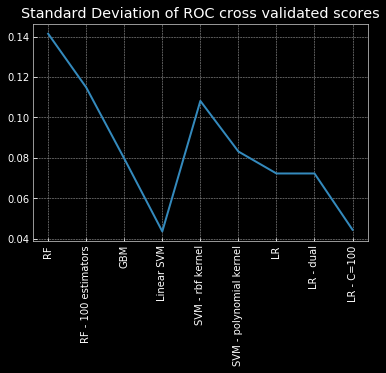

In [31]:
stds = [rf_std, rf_100_std, lgb_std, clf_lin_std, clf_std, clf_poly_std, lr_std, lr_dual_std, lr_100_std]
names = ['RF', 'RF - 100 estimators', 'GBM', 'Linear SVM', 'SVM - rbf kernel', 'SVM - polynomial kernel', 'LR', 'LR - dual', 'LR - C=100']
plt.plot(names, stds)
plt.xticks(rotation=90)
plt.title('Standard Deviation of ROC cross validated scores')

# Hyperparams Tuning

## SVM

In [32]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    degrees = [2, 3, 4, 5]
    param_grid = {'C': Cs, 'kernel' : kernels, 'degree': degrees}
    grid_search = GridSearchCV(SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [33]:
# takes 4 min to run
# best_params = svc_param_selection(x_train, y_train, 10)
# best_params # were {'C': 0.01, 'degree': 2, 'kernel': 'linear'}

Accuracy =  0.9615 - ROC = 0.9583 -  CV score mean = 0.9557 - CV score std = 0.0436


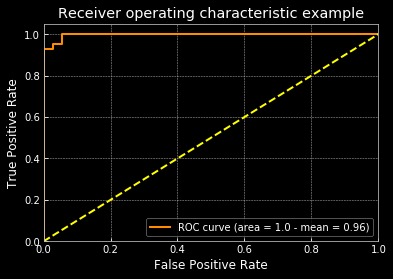

(0.96153846153846156,
 0.95833333333333326,
 0.95565476190476184,
 0.043601275123163932)

In [34]:
clf = SVC(random_state=42 , C= 0.1, kernel= 'linear', probability=True)
train(clf, x_train, y_train, x_test, y_test)

Accuracy =  0.5385 - ROC = 0.5 -  CV score mean = 0.5007 - CV score std = 0.02643


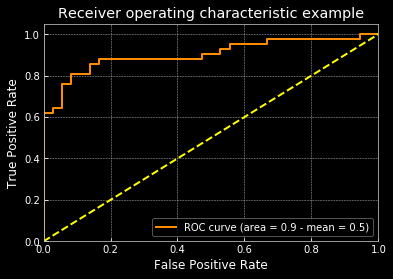

(0.53846153846153844, 0.5, 0.50069444444444444, 0.026434536542603172)

In [35]:
clf = SVC(random_state=42 , C = 10, kernel = 'poly', degree = 5, probability=True) 
train(clf, x_train, y_train, x_test, y_test)

Linear SVM performs better than polynomial kernel SVM.

## Logistic Regression

In [36]:
def lr_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100]
    dual = [False]
    solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
    reg = ['l1', 'l2']
    param_grid = {'C': Cs ,
                  'dual': dual,
                  'solver': solvers
                 }

    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


In [37]:
# best_lr_params = lr_param_selection(x_train, y_train, 10)
# best_lr_params # were {'C': 0.001, 'dual': False, 'solver': 'newton-cg'}

Accuracy =  0.9487 - ROC = 0.9444 -  CV score mean = 0.9628 - CV score std = 0.04442


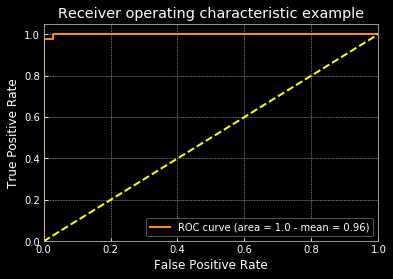

(0.94871794871794868,
 0.94444444444444442,
 0.96279761904761918,
 0.044422405427109193)

In [38]:
lr = LogisticRegression(random_state=42, C = 100, dual= False)
train(lr, x_train, y_train, x_test, y_test)

# Genetic Algorithm for choosing the best pipeline

In [39]:
from tpot import TPOTClassifier

In [40]:
# auto_ml = TPOTClassifier(generations = 100, population_size = 100, scoring = 'balanced_accuracy', n_jobs = 4, random_state = 42, warm_start = True, verbosity = 2)
# auto_ml.fit(x_train, y_train)

In [41]:
# auto_ml.export('tpot_exported_pipeline.py')

# Saving submission file

Accuracy =  0.9615 - ROC = 0.9583 -  CV score mean = 0.9557 - CV score std = 0.0436


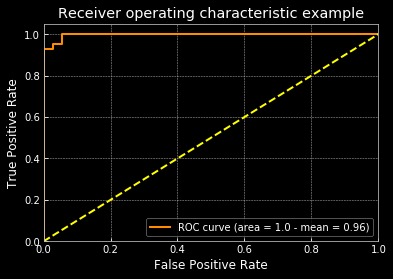

(0.96153846153846156,
 0.95833333333333326,
 0.95565476190476184,
 0.043601275123163932)

In [42]:
# Best pipeline from TPOT: 
lsvm = SVC(kernel = 'linear', C=1, probability=True) 
lsvm.fit(x_train, y_train)
train(lsvm, x_train, y_train.reshape(-1,), x_test, y_test.reshape(-1,))


In [43]:
x_train.shape

(158, 358)

In [44]:
df_test.iloc[:, good_features].values.shape

y_final = lsvm.predict(df_test.iloc[:, good_features])
with open('ytest_labels.txt', 'w') as out_file:
    for line in y_final:
        out_file.write(str(line)+'\n')
        
y_real_valued = df_test.iloc[:, good_features] @ lsvm.coef_.T
y_real_valued = y_real_valued.values.reshape(-1)
with open('ytest_realvalued.txt', 'w') as out_file:
    for line in y_real_valued:
        out_file.write(str(line)+'\n')

# Feature selection trials

## F-Test

F-Test is useful in feature selection as we get to know the significance of each feature in improving the model.

In [45]:
# F, pval = f_classif(x, y)
# idx = np.argsort(-F)

In [46]:
# x_red = df_lasso[:,idx[0:50]]
# y_red = np.array(y_res)
# x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x_red, y_red, test_size=0.33, random_state=42)

In [47]:
# lr = LogisticRegression(random_state=42, dual =True) # best one till now
# train(lr, x_train_red, y_train_red, x_test_red, y_test_red)

# xgb = XGBClassifier(learning_rate=0.1, n_estimators=100)
# train(xgb, x_train_red, y_train_red, x_test_red, y_test_red)

# lsvm = LinearSVC(C=1)
# lsvm.fit(x_train, y_train)
# train(lsvm, x_train, y_train.reshape(-1,), x_test, y_test.reshape(-1,))

In [48]:
# # best_params = svc_param_selection(x_train_red, y_train_red, 10)
# # best_params # were {'C': 0.001, 'degree': 5, 'kernel': 'poly'}
# clf = SVC(C = 0.001, kernel = 'poly', degree = 5)
# train(clf, x_train_red, y_train_red, x_test_red, y_test_red)

In [49]:
# num_feats = np.linspace(3, 50, 30)

# for f in num_feats:
#     df_new = df_main.iloc[:,idx[0:int(f)]]
#     df_new['y'] = df_y[0:]

#     x_red = df_new.drop(['y'], axis = 1).values
#     y_red = np.array(df_new.y.values)

#     x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x, y, test_size=0.33, random_state=42)

#     lr = LogisticRegression(random_state=42, dual =True) # best one till now
#     train(lr, x_train_red, y_train_red, x_test_red, y_test_red)

## Mututal Information

In [50]:
# mi = mutual_info_classif(x, y)
# idx_mi = np.argsort(-mi)

In [51]:
# df_new = df_main.iloc[:,idx_mi[0:100]]
# df_new['y'] = df_y[0:]

# x_red = df_new.drop(['y'], axis = 1).values
# y_red = np.array(df_new.y.values)

# x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x_red, y_red, test_size=0.33, random_state=42)

# lr = LogisticRegression(random_state=42, dual =True) # best one till now
# train(lr, x_train_red, y_train_red, x_test_red, y_test_red)
# kfold = KFold(n_splits=10, random_state=42)
# result = cross_val_score(lr, x_train_red, y_train_red, cv=kfold, scoring='balanced_accuracy')
# result.mean()

## Chi

In [52]:
# # from sklearn.feature_selection import chi2

# chi_scores, _ = chi2(x, y)

# idx_chi = np.argsort(-chi_scores)
# df_new = df_main.iloc[:,idx_chi[0:100]]
# df_new['y'] = df_y[0:]

# x_red = df_new.drop(['y'], axis = 1).values
# y_red = np.array(df_new.y.values)

# x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(x_red, y_red, test_size=0.33, random_state=42)

# lr = LogisticRegression(random_state=42, dual =True) # best one till now
# train(lr, x_train_red, y_train_red, x_test_red, y_test_red)

# kfold = KFold(n_splits=10, random_state=42)
# result = cross_val_score(lr, x_train_red, y_train_red, cv=kfold, scoring='balanced_accuracy')
# result.mean()

## Variance Threshold

In [53]:
# from sklearn.feature_selection import VarianceThreshold

# sel = VarianceThreshold()
# selected_feats = sel.fit_transform(x)
# selected_feats.shape

# Feature Engineering Trials - incomplete

In [54]:
import featuretools as ft

In [55]:
df = df.reset_index()
es = ft.EntitySet(id='main_df')
es = es.entity_from_dataframe(entity_id= 'main_df', dataframe=df)#, make_index=False)

2019-03-10 18:46:41,338 featuretools.entityset - WARNING    ('Using first column as index. ', 'To change this, specify the index parameter')


# Tips from discussion

## Feature selection:

`1` REFCV.<br>
`2` SelektFROMModel. <br>
`3` TuRF. <br>
`4` ISOMAP. <br>
`5` locally linear embeddings. <br>
`6` label propagation. <br>
`7` gaussian random projection (used for high number of data points).


## Try different models:

`1` NU SVC. <br>
`2` GBClassifier. <br>
`3` Vooting ensembles (stacking). <br>
`4` SVM with custom kernel. <br>
`5` kernel ridge regression. <br>
`6` Gaussian processes.

## Overcome overfitting by:

`1` Split the dataset 70-15-15 randomly several times. <br>
`2` Average over different seeds and compute std. <br>
`3` Use different metric (e.g. use F1 score to select best model).

## For model selection:
`1` MKLBO (multi kernel learning bayesian optimization) clustering over MKLBO. <br>
`2` Try tpot for model selection.

## Final note
Trained model by Yang: LinearSVC with all the features.